## Stroke Prediction  
**Vinay Nagaraj**

### Overview

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. A Report from the American Heart Association informs that an average, someone in the US has a stroke every 40 seconds. 

Stroke is a treatable disease, and if detected or predicted early, its severity can be greatly reduced. If stroke can be predicted at an early stage there is 4% lower risk of in-hospital death, 4% better odds of walking independently after leaving the hospital and also 3% better odds of being sent home instead of to an institution.

As part of this project, I will be using the dataset from [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) by which I intend to consider all the relevant information about the patient such as gender, age, various diseases, and smoking and build predictive analytics techniques that would predict the patients with high risk and is likely to get stroke. This helps in providing the advanced warning to alert the patients so that they can apply proper precautions and possibly the prevent the stroke.

In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [2]:
# Read our data
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
# Check the dimension of the data frame
print("The dimension of the table is: ", stroke_data.shape)

The dimension of the table is:  (5110, 12)


In [4]:
# Lets look at some sample records to understand the data
print(stroke_data.head(5).T)

                                 0              1             2        3  \
id                            9046          51676         31112    60182   
gender                        Male         Female          Male   Female   
age                             67             61            80       49   
hypertension                     0              0             0        0   
heart_disease                    1              0             1        0   
ever_married                   Yes            Yes           Yes      Yes   
work_type                  Private  Self-employed       Private  Private   
Residence_type               Urban          Rural         Rural    Urban   
avg_glucose_level           228.69         202.21        105.92   171.23   
bmi                           36.6            NaN          32.5     34.4   
smoking_status     formerly smoked   never smoked  never smoked   smokes   
stroke                           1              1             1        1   

           

In [5]:
# Check the types of each feature
stroke_data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
# Check for any missing values
stroke_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
# First let us round off Age to convert it to integer
stroke_data['age'] = stroke_data['age'].apply(lambda x : round(x))

# BMI values less than 12 and greater than 60 are potential outliers. So we will change them to NaN
stroke_data['bmi'] = stroke_data['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

# Sorting DataFrame based on Gender then on Age and using Forward Fill-ffill() to fill NaN value for BMI
stroke_data.sort_values(['gender', 'age'], inplace=True) 
stroke_data.reset_index(drop=True, inplace=True)
stroke_data['bmi'].ffill(inplace=True)

In [8]:
# Check for any missing values
stroke_data.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Data Summary**
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- stroke: 1 if the patient had a stroke or 0 if not\
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [9]:
stroke_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.818474,0.048728
std,21161.721625,22.612731,0.296607,0.226063,45.283560,7.514838,0.215320
min,67.000000,0.000000,0.000000,0.000000,55.120000,12.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.600000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.000000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,59.700000,1.000000


In [10]:
# Understand the categorical data in our dataset
for column in stroke_data.columns:
  if stroke_data[column].dtype == object:
    print("{} : {}".format(str(column), str(stroke_data[column].unique())))
    print(stroke_data[column].value_counts())
    print("-----------------------------------------------------\n\n")

gender : ['Female' 'Male' 'Other']
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
-----------------------------------------------------


ever_married : ['No' 'Yes']
Yes    3353
No     1757
Name: ever_married, dtype: int64
-----------------------------------------------------


work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
-----------------------------------------------------


Residence_type : ['Rural' 'Urban']
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
-----------------------------------------------------


smoking_status : ['Unknown' 'formerly smoked' 'never smoked' 'smokes']
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
-----------------------------------------------------




In [11]:
# Drop 'id' feature as it is irrelevant. 
stroke_data = stroke_data.drop('id', axis=1)

Below are our observations so far:\
1) Input data has 5110 records and 12 features.\
2) bmi had 201 rows of missing values which is now filled using Forward Fill.\
3) 'id' is an irrelevant features to our analysis, so was dropped.

### Graph Analysis/EDA

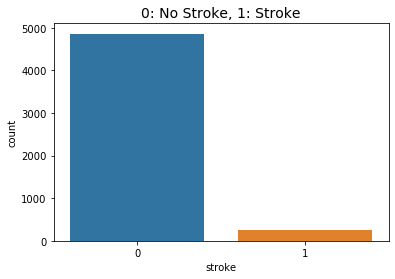

In [12]:
# Plot of Patients who had stroke vs Patients who did not have stroke

sns.countplot('stroke', data=stroke_data)
plt.title('0: No Stroke, 1: Stroke', fontsize=14)
plt.show()

In [13]:
# Percentage of Patients who had stroke vs Patients who did not have stroke
Count_stroke_patients = len(stroke_data[stroke_data["stroke"]==1]) # Patients who had stroke
Count_nostroke_patients = len(stroke_data[stroke_data["stroke"]==0]) # Patients who never had stroke
print("Total count of Patients who had stroke       = ",Count_stroke_patients)
print("Total count of Patients who never had stroke = ",Count_nostroke_patients)
Percentage_of_stroke_patients = Count_stroke_patients/(Count_stroke_patients+Count_nostroke_patients)
print("Percentage of Patients who had stroke        = ",Percentage_of_stroke_patients*100)
Percentage_of_nostroke_patients= Count_nostroke_patients/(Count_nostroke_patients+Count_stroke_patients)
print("Percentage of Patients who never had stroke  = ",Percentage_of_nostroke_patients*100)

Total count of Patients who had stroke       =  249
Total count of Patients who never had stroke =  4861
Percentage of Patients who had stroke        =  4.87279843444227
Percentage of Patients who never had stroke  =  95.12720156555773


Our Dataset contains a total of 4,861 rows of patients who never had stroke and 249 rows of patients who had stroke. We can observe that our dataset is highly imbalanced and we will handle that by over-sampling (SMOTE) before we perform model analysis.

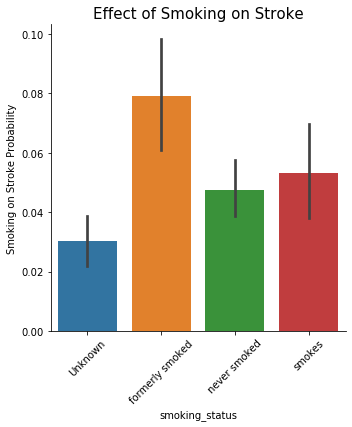

In [14]:
# plot the effect of Smoking on Stroke

g= sns.catplot(x = "smoking_status", y = "stroke", data = stroke_data, kind = "bar", height = 5)
g.set_ylabels("Smoking on Stroke Probability")
plt.title("Effect of Smoking on Stroke",fontsize=15)
plt.xticks(rotation=45)
plt.show()

Being a smoker or a formerly smoker increases your risk of having a stroke. Also, looks like people who used to smoke are more prone to a Stroke than people still smoking. But surely Smoking is injurious to health. 

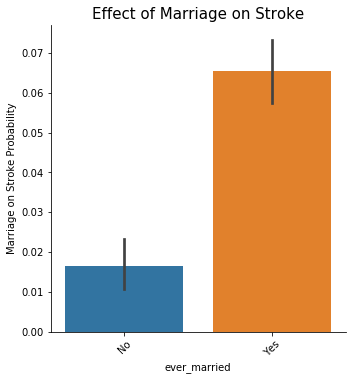

In [15]:
# plot the effect of Marriage on Stroke

g= sns.catplot(x = "ever_married", y = "stroke", data = stroke_data, kind = "bar", height = 5)
g.set_ylabels("Marriage on Stroke Probability")
plt.title("Effect of Marriage on Stroke",fontsize=15)
plt.xticks(rotation=45)
plt.show()

Wasn't this obvious :)

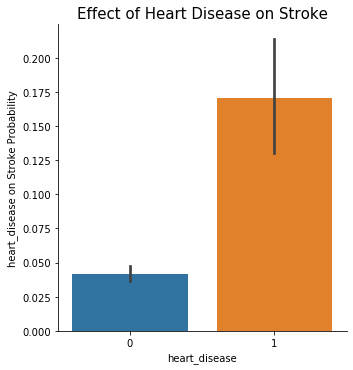

In [16]:
# plot the effect of Heart Disease on Stroke

g= sns.catplot(x = "heart_disease", y = "stroke", data = stroke_data, kind = "bar", height = 5)
g.set_ylabels("heart_disease on Stroke Probability")
plt.title("Effect of Heart Disease on Stroke",fontsize=15)
plt.show()

People with a history of heart disease are more prone to Stroke

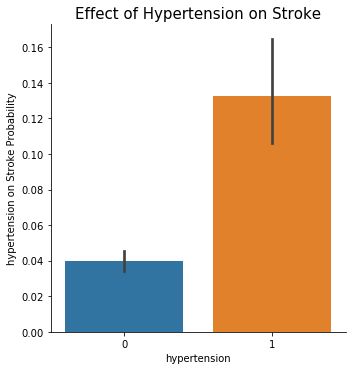

In [17]:
# plot the effect of Hypertension on Stroke

g= sns.catplot(x = "hypertension", y = "stroke", data = stroke_data, kind = "bar", height = 5)
g.set_ylabels("hypertension on Stroke Probability")
plt.title("Effect of Hypertension on Stroke",fontsize=15)
plt.show()

People with a history of Hypertension are more prone to Stroke

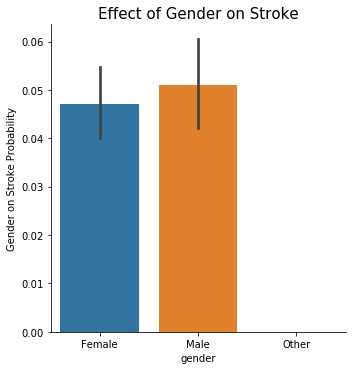

In [18]:
# plot the effect of Gender on Stroke

g= sns.catplot(x = "gender", y = "stroke", data = stroke_data, kind = "bar", height = 5)
g.set_ylabels("Gender on Stroke Probability")
plt.title("Effect of Gender on Stroke",fontsize=15)
plt.show()

Male are more prone to Stroke when compared to Females.

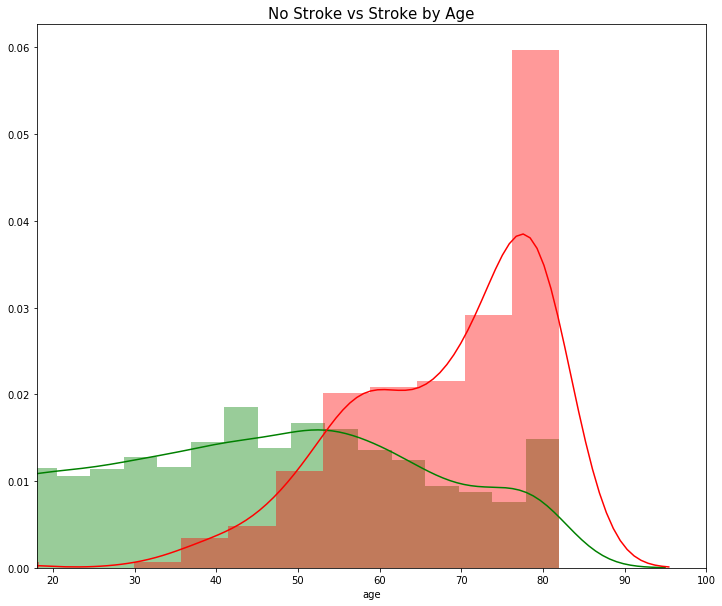

In [19]:
# Stroke distribution by age Age

plt.figure(figsize=(12,10))

sns.distplot(stroke_data[stroke_data['stroke'] == 0]["age"], color='green') # No Stroke - green
sns.distplot(stroke_data[stroke_data['stroke'] == 1]["age"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Age', fontsize=15)
plt.xlim([18,100])
plt.show()

Based on the above plot, it seems clear that Age is a big factor in stroke patients - the older you get the more at risk you are.

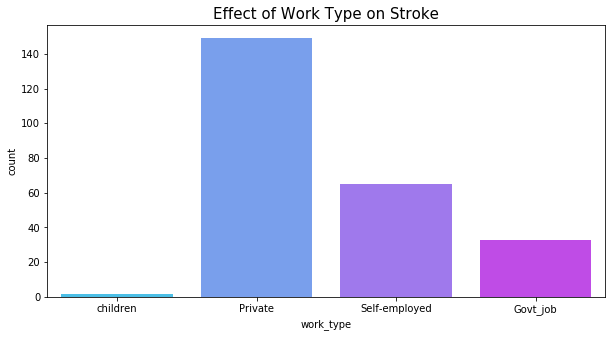

In [20]:
# plot the effect of work-type on Stroke

plt.figure(figsize=(10,5))
sns.countplot(data=stroke_data[stroke_data["stroke"]==1],x='work_type',palette='cool')
plt.title("Effect of Work Type on Stroke",fontsize=15)
plt.show()

Private work type exposes you to more stroke, than being self-employed or Govt work.

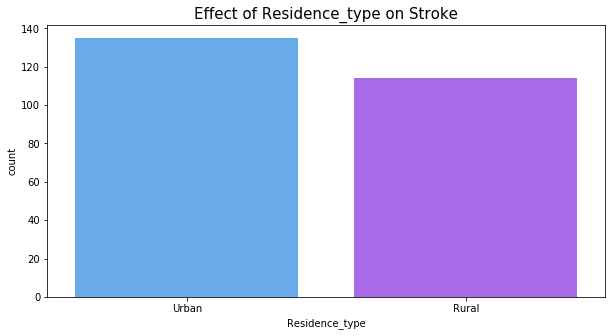

In [21]:
# plot the effect of Residence_type on Stroke

plt.figure(figsize=(10,5))
sns.countplot(data=stroke_data[stroke_data["stroke"]==1],x='Residence_type',palette='cool')
plt.title("Effect of Residence_type on Stroke",fontsize=15)
plt.show()

People staying in Urban areas are more prone to Stroke

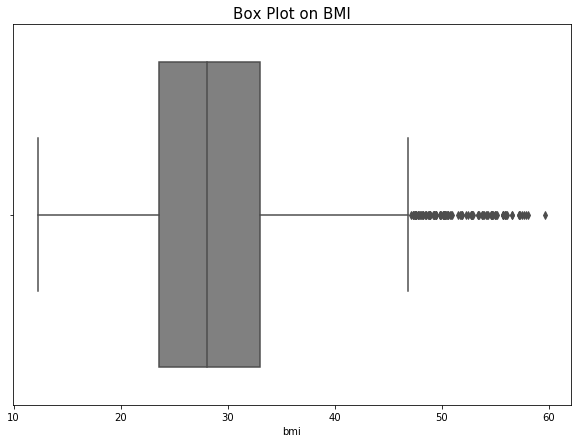

In [22]:
# BMI Box Plot

plt.figure(figsize=(10,7))
sns.boxplot(data=stroke_data,x=stroke_data["bmi"],color='gray')
plt.title("Box Plot on BMI",fontsize=15)
plt.show()

### Train/Test

In [23]:
# Update the data in gender column, by changing value of Female to 0, Male to 1 and Other to 2
stroke_data['gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}, inplace = True)

In [24]:
# Update the data in ever_married column, by changing value of Yes to 0 and No to 1
stroke_data['ever_married'].replace({'Yes': 0, 'No': 1}, inplace = True)

In [25]:
# Update the data in work_type column, by changing value of Private to 0, Self-employed to 1, children to 2, Govt_job to 3 and Never_worked to 4
stroke_data['work_type'].replace({'Private': 0, 'Self-employed': 1, 'children': 2, 'Govt_job': 3, 'Never_worked': 4}, inplace = True)

In [26]:
# Update the data in Residence_type column, by changing value of Urban to 0 and Rural to 1
stroke_data['Residence_type'].replace({'Urban': 0, 'Rural': 1}, inplace = True)

In [27]:
# Update the data in smoking_status column, by changing value of never smoked to 0, formerly smoked to 1, smokes to 2 and Unknown to 3
stroke_data['smoking_status'].replace({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3}, inplace = True)

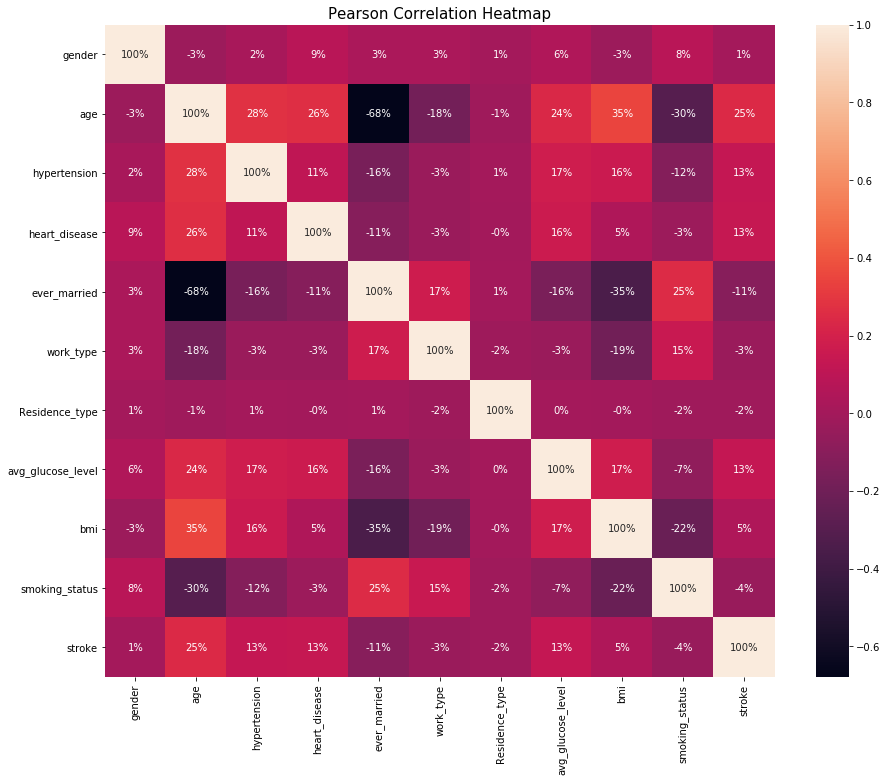

In [28]:
# Pearson Correlation Heatmap
plt.subplots(figsize=(15,12))
sns.heatmap(stroke_data.corr(method = 'pearson'), annot=True, fmt='.0%')
plt.title("Pearson Correlation Heatmap",fontsize=15)
plt.show()

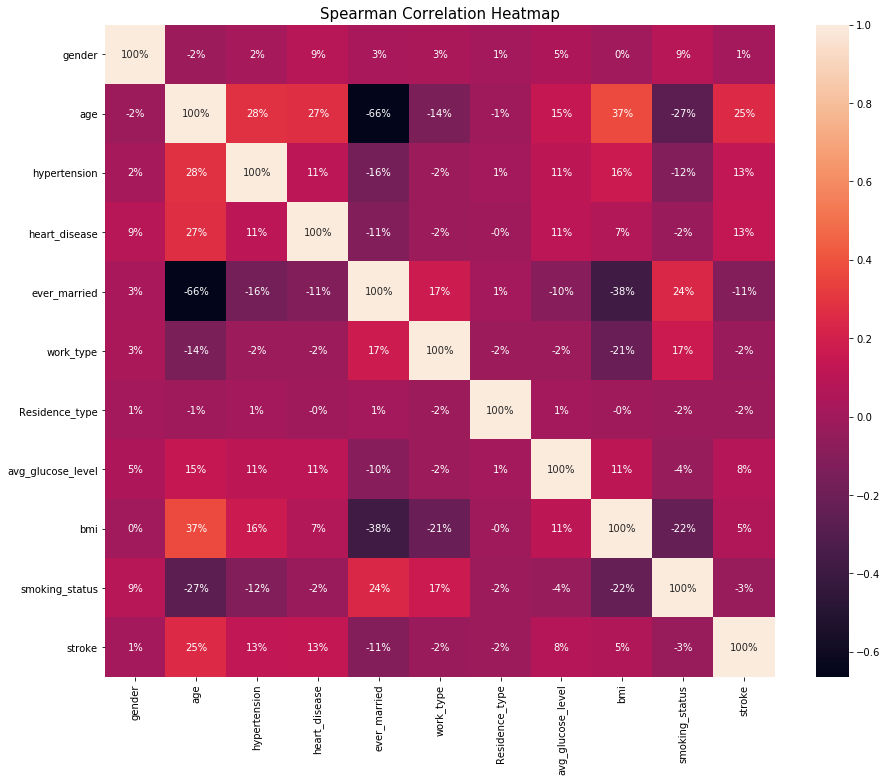

In [29]:
# Spearman Correlation Heatmap
plt.subplots(figsize=(15,12))
sns.heatmap(stroke_data.corr(method = 'spearman'), annot=True, fmt='.0%')
plt.title("Spearman Correlation Heatmap",fontsize=15)
plt.show()

In [30]:
# Train and test data
x=stroke_data.drop(columns=["stroke"],axis="columns")
y=stroke_data.stroke

In [31]:
x.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,0,0,0,1,2,1,73.71,16.2,3
1,0,0,0,0,1,2,1,55.86,16.0,3
2,0,0,0,0,1,2,0,139.67,14.1,3
3,0,0,0,0,1,2,1,118.75,17.4,3
4,0,0,0,0,1,2,1,85.65,17.4,3


In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=42)

Transaction Number x_train dataset:  (3577, 10)
Transaction Number y_train dataset:  (3577,)
Transaction Number x_test dataset:  (1533, 10)
Transaction Number y_test dataset:  (1533,)
Before OverSampling, counts of label '1': 172
Before OverSampling, counts of label '0': 3405 



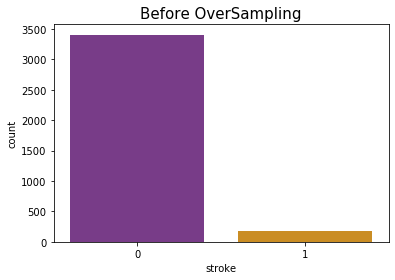

In [33]:
# Details of training dataset
print("Transaction Number x_train dataset: ", x_train.shape)
print("Transaction Number y_train dataset: ", y_train.shape)
print("Transaction Number x_test dataset: ", x_test.shape)
print("Transaction Number y_test dataset: ", y_test.shape)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sns.countplot(x=y_train, data=stroke_data, palette='CMRmap')
plt.title("Before OverSampling",fontsize=15)
plt.show()

As we see above, the dataset is highly imbalanced as most of the records belong to Patients who never had a stroke. Therefore the algorithms are much more likely to classify new observations to the majority class and high accuracy won't tell us anything. In order to address this challenge, we are using oversampling data approach instead of undersampling. Oversampling increases the number of minority class members in the training set. The advantage of oversampling is that no information from the original training set is lost unlike in undersampling, as all observations from the minority and majority classes are kept.

Since this approach is prone to overfitting, we have to be cautious. We are using oversampling technique called SMOTE (Synthetic Minority Oversampling Technique), to make our dataset balanced. It creates synthetic points from the minority class.

After OverSampling, the shape of x_train: (6810, 10)
After OverSampling, the shape of y_train: (6810,) 

After OverSampling, counts of label '1', %: 50.0
After OverSampling, counts of label '0', %: 50.0


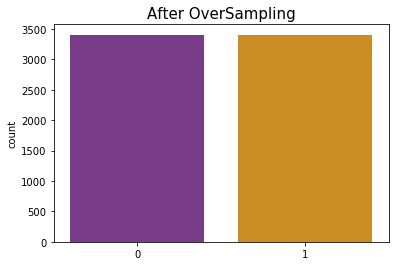

In [34]:
# Oversample the training dataset
sm = SMOTE(random_state=2)
x_train_s, y_train_s = sm.fit_resample(x_train, y_train.ravel())

print('After OverSampling, the shape of x_train: {}'.format(x_train_s.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_s.shape))

print("After OverSampling, counts of label '1', %: {}".format(sum(y_train_s==1)/len(y_train_s)*100.0,2))
print("After OverSampling, counts of label '0', %: {}".format(sum(y_train_s==0)/len(y_train_s)*100.0,2))

sns.countplot(x=y_train_s, data=stroke_data, palette='CMRmap')
plt.title("After OverSampling",fontsize=15)
plt.show()

In [35]:
# Determine 10 best features using SelectKBest
best_features = SelectKBest(score_func=f_classif, k=10)
fit = best_features.fit(x_train_s,y_train_s)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x_train_s.columns)
# concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # name output columns
print(feature_scores.nlargest(10,'Score'))         # print 10 best features

        Feature_Name        Score
1                age  3699.286002
4       ever_married  1497.263575
6     Residence_type   697.341641
9     smoking_status   566.053559
5          work_type   444.715259
0             gender   433.348371
7  avg_glucose_level   427.592481
8                bmi    96.809699
2       hypertension     0.111912
3      heart_disease     0.000000


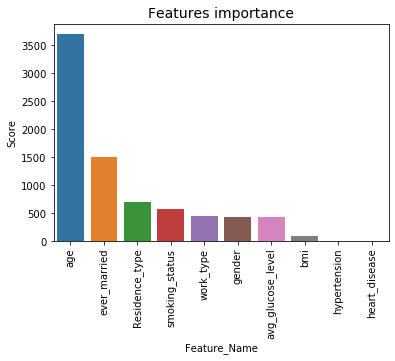

In [36]:
# Bar plot showing features in the order of score
tmp = feature_scores.sort_values(by='Score',ascending=False) 
plt.title('Features importance',fontsize=14) 
s = sns.barplot(x='Feature_Name',y='Score',data=tmp) 
s.set_xticklabels(s.get_xticklabels(),rotation=90) 
plt.show()

### Model Evaluation & Selection

#### Random Forest Classifier

In [37]:
rf = RandomForestClassifier()
rf.fit(x_train_s,y_train_s)
rf_predict = rf.predict(x_test)

dec = np.int64(np.ceil(np.log10(len(y_test))))
print('Confusion Matrix - Random Forest')
print(confusion_matrix(y_test, rf_predict), '\n')

print('Classification report - Random Forest')
print(classification_report(y_test,rf_predict, digits=dec), '\n')

print('Random Forest Accuracy Score = ', accuracy_score(y_test,rf_predict)*100)

Confusion Matrix - Random Forest
[[1345  111]
 [  62   15]] 

Classification report - Random Forest
              precision    recall  f1-score   support

           0     0.9559    0.9238    0.9396      1456
           1     0.1190    0.1948    0.1478        77

    accuracy                         0.8871      1533
   macro avg     0.5375    0.5593    0.5437      1533
weighted avg     0.9139    0.8871    0.8998      1533
 

Random Forest Accuracy Score =  88.71493803000652


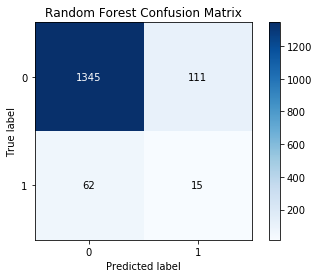

In [38]:
skplt.metrics.plot_confusion_matrix(y_test,rf_predict)
plt.title('Random Forest Confusion Matrix')
plt.show()

#### k-Nearest Neighbors

In [39]:
kn = KNeighborsClassifier(n_neighbors=4)
kn.fit(x_train_s,y_train_s)
kn_predict = kn.predict(x_test)

print('Confusion Matrix - kNN')
print(confusion_matrix(y_test, kn_predict), '\n')

print('Classification report - kNN')
print(classification_report(y_test,kn_predict, digits=dec), '\n')

print('k-Nearest Neighbor Accuracy Score = ', accuracy_score(y_test,kn_predict)*100)

Confusion Matrix - kNN
[[1249  207]
 [  49   28]] 

Classification report - kNN
              precision    recall  f1-score   support

           0     0.9622    0.8578    0.9070      1456
           1     0.1191    0.3636    0.1795        77

    accuracy                         0.8330      1533
   macro avg     0.5407    0.6107    0.5433      1533
weighted avg     0.9199    0.8330    0.8705      1533
 

k-Nearest Neighbor Accuracy Score =  83.30071754729289


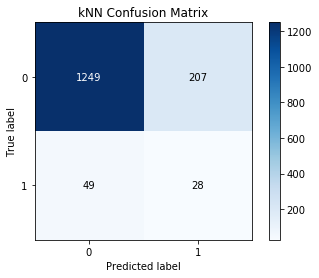

In [40]:
skplt.metrics.plot_confusion_matrix(y_test,kn_predict)
plt.title('kNN Confusion Matrix')
plt.show()

#### Decision Tree Classifier

In [41]:
dt = DecisionTreeClassifier()
dt.fit(x_train_s,y_train_s)
dt_predict = dt.predict(x_test)

print('Confusion Matrix - Decision Tree')
print(confusion_matrix(y_test, dt_predict), '\n')

print('Classification report - Decision Tree')
print(classification_report(y_test,dt_predict, digits=dec), '\n')

print('Decision Tree Accuracy Score = ', accuracy_score(y_test,dt_predict)*100)

Confusion Matrix - Decision Tree
[[1295  161]
 [  55   22]] 

Classification report - Decision Tree
              precision    recall  f1-score   support

           0     0.9593    0.8894    0.9230      1456
           1     0.1202    0.2857    0.1692        77

    accuracy                         0.8591      1533
   macro avg     0.5397    0.5876    0.5461      1533
weighted avg     0.9171    0.8591    0.8852      1533
 

Decision Tree Accuracy Score =  85.90998043052838


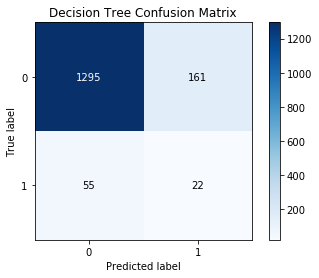

In [42]:
skplt.metrics.plot_confusion_matrix(y_test,dt_predict)
plt.title('Decision Tree Confusion Matrix')
plt.show()

### Conclusion 

- We see that age, ever_married, smoking_status are the most important features when it comes to predicting stroke-prone individuals, based on the current dataset.
- Age is an important factor in Stroke patients. So it is necessary to take care of our health as we grow older and make sure not to miss out on our annual checkups.
- Smoking is injurious to health and can increase the chances of Stroke
- People staying in Urban areas are more prone to Stroke when compared to Rural areas.
- SMOTE Technique used to overcome imbalanced data.
- Among all the algorithms we used Random Forest was best suited with accuracy of 88.71%